# Домашнее задание. Свёрточные сети

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10.

In [1]:
import tensorflow as tf
import tqdm
import keras
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

## Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [2]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape,y_train.shape)

(40000, 32, 32, 3) (40000, 1)


Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

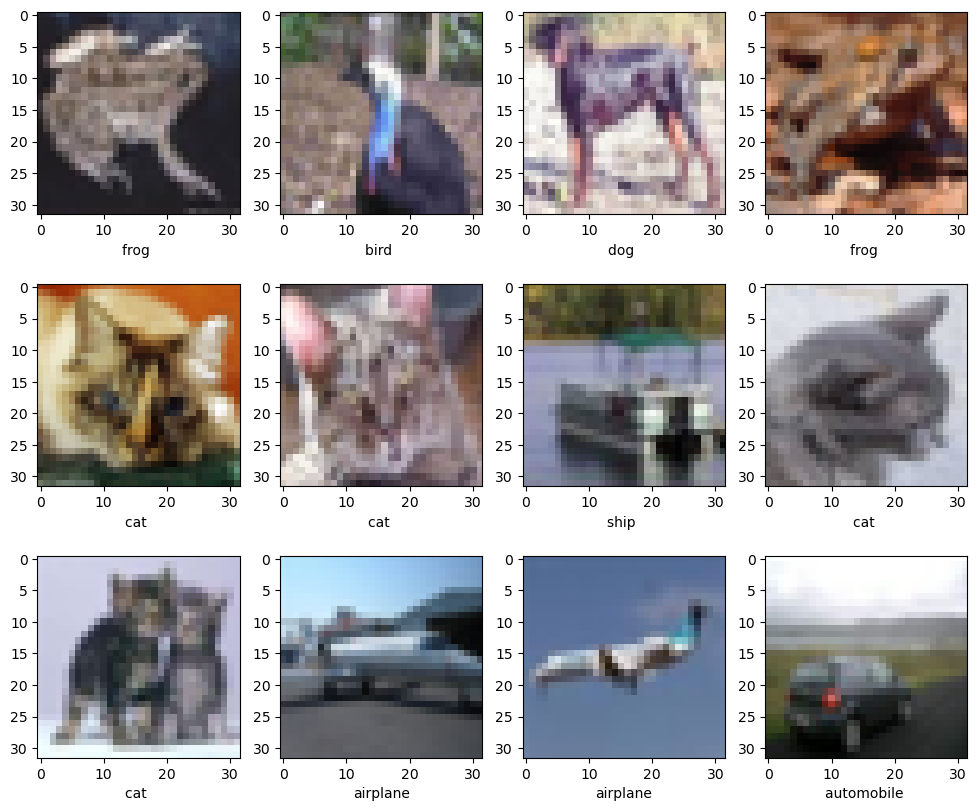

In [3]:
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент:

In [4]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

Исполните код ниже для проверки, что все выполнено корректно.

In [5]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
1. принимает на вход картинки размера 32 x 32 x 3;
2. вытягивает их в вектор (`keras.layers.Flatten`);
3. пропускает через 1 или 2 полносвязных слоя;
4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

Создайте полносвязную сеть:

In [6]:
from tensorflow.keras.models import Sequential
from keras import layers as L
from keras import backend as K

In [7]:
model = Sequential([
    L.Flatten(input_shape=(32, 32, 3)),
    L.Dense(256, activation='relu'),
    L.Dense(10, activation='softmax')
  ])

In [8]:
dummy_pred = model.predict(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print("Успех!")

1/1 [==============================] - 0s 123ms/step
Успех!


## Обучение сети

**Задание 1.1 (обязательно)** Будем минимизировать многоклассовую кроссэкнропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

__Важно:__ поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать метки в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в [tensorboard](https://keras.io/callbacks/#tensorboard) или [wandb](https://docs.wandb.ai/integrations/jupyter). **Важно: логи tensorboard не получится без боли посмотреть через colab.** Workaround: скачать логи и запустить tensorboard локально или помучаться [с этим](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у Кераса есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или подбор скорости обучения.

In [9]:
y_train, y_val = (keras.utils.to_categorical(y) for y in (y_train, y_val))

In [10]:
# Определение callback с параметром, который отвечает за прекращение обучения, когда отслеживаемый показатель перестанет улучшаться.

callback = [tf.keras.callbacks.EarlyStopping(patience = 2, baseline = 0.45)]


> **Комментарий:** 
1. поигрался с Learning rate (Скорость обучения) и 
2. momentum (гиперпараметр float >= 0, который ускоряет градиентный спуск в <br>
соответствующем направлении и гасит колебания. По умолчанию 0, т. е. стандартный <br>
градиентный спуск.) <p>
Подобрал, с большой долей вероятности, лучший вариант, по моему мнению.
    
___

In [11]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers.legacy import SGD


loss_fn = categorical_crossentropy
optimiser_sgd = SGD(learning_rate = 0.01, momentum = 0.45) 


In [12]:
# Создание модели

model.compile(optimizer = optimiser_sgd,
              loss = loss_fn, 
              metrics = ['accuracy']
             )


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 256)               786688    
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 789258 (3.01 MB)
Trainable params: 789258 (3.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# Тренируем модель

history = model.fit(X_train,
                    y_train,
                    epochs = 10,
                    validation_data = (X_val, y_val),
                    callbacks = callback)

Epoch 1/10
1250/1250 [==============================] - 10s 8ms/step - loss: 1.8699 - accuracy: 0.3310 - val_loss: 1.7295 - val_accuracy: 0.3839
Epoch 2/10
1250/1250 [==============================] - 9s 8ms/step - loss: 1.6874 - accuracy: 0.4049 - val_loss: 1.6430 - val_accuracy: 0.4217
Epoch 3/10
1250/1250 [==============================] - 9s 7ms/step - loss: 1.6102 - accuracy: 0.4336 - val_loss: 1.6374 - val_accuracy: 0.4253
Epoch 4/10
1250/1250 [==============================] - 9s 7ms/step - loss: 1.5556 - accuracy: 0.4516 - val_loss: 1.5451 - val_accuracy: 0.4577
Epoch 5/10
1250/1250 [==============================] - 9s 7ms/step - loss: 1.5147 - accuracy: 0.4668 - val_loss: 1.5707 - val_accuracy: 0.4366


А теперь можно проверить качество вашей сети, выполнив код ниже:

In [15]:
from sklearn.metrics import accuracy_score

predict_x = model.predict(X_test)
classes_x = np.argmax(predict_x,axis = 1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 [==============================] - 1s 2ms/step

 Test_acc = 0.4528
 Not bad!


In [16]:
# Функция графика точности модели

def plothist(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

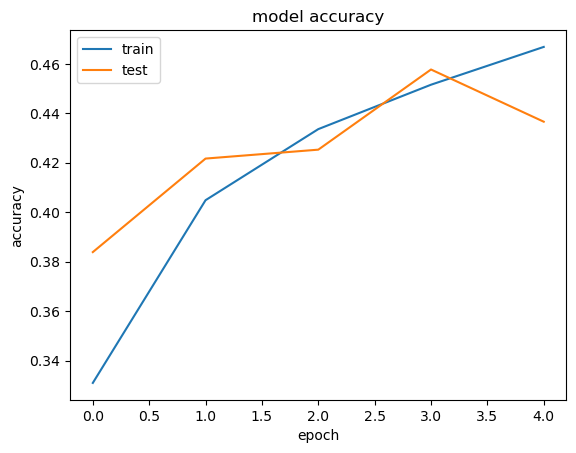

In [17]:
plothist(history)

## Карманная сверточная сеть

**Задание 1.2 (обязательно)** Реализуйте небольшую свёрточную сеть. Совсем небольшую:
1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [18]:
pocket_model = Sequential([
    L.Conv2D(filters = 15,
             kernel_size = (5, 5),
             padding = 'same',
             activation = 'relu',
             input_shape = (32, 32, 3)),
    
    L.Conv2D(filters = 10,
             kernel_size = (3, 3),
             padding = 'same',
             activation = 'relu'),
    
    L.MaxPool2D(pool_size = (2, 2), padding = 'valid'),

#######################################

    L.Flatten(),# (N,C,H,W) --> (N, C*H*W)
    L.Dense(100, activation = 'relu'),
    L.Dense(10, activation = 'softmax')])


In [19]:

pocket_model.compile(optimizer = 'adam',
                     loss = loss_fn,
                     metrics = ['accuracy'])

In [20]:
history_2 = pocket_model.fit(X_train,
                 y_train,
                 epochs = 10,
                 validation_data = (X_val, y_val),
                 callbacks = [tf.keras.callbacks.EarlyStopping(patience = 2, baseline = 0.51)])

Epoch 1/10
1250/1250 [==============================] - 55s 43ms/step - loss: 1.5864 - accuracy: 0.4314 - val_loss: 1.3467 - val_accuracy: 0.5276
Epoch 2/10
1250/1250 [==============================] - 57s 46ms/step - loss: 1.2768 - accuracy: 0.5455 - val_loss: 1.2360 - val_accuracy: 0.5631
Epoch 3/10
1250/1250 [==============================] - 57s 46ms/step - loss: 1.1432 - accuracy: 0.5951 - val_loss: 1.2017 - val_accuracy: 0.5788
Epoch 4/10
1250/1250 [==============================] - 56s 45ms/step - loss: 1.0468 - accuracy: 0.6302 - val_loss: 1.1428 - val_accuracy: 0.5961
Epoch 5/10
1250/1250 [==============================] - 59s 47ms/step - loss: 0.9615 - accuracy: 0.6625 - val_loss: 1.1288 - val_accuracy: 0.6061
Epoch 6/10
1250/1250 [==============================] - 55s 44ms/step - loss: 0.8909 - accuracy: 0.6869 - val_loss: 1.1078 - val_accuracy: 0.6184
Epoch 7/10
1250/1250 [==============================] - 55s 44ms/step - loss: 0.8203 - accuracy: 0.7089 - val_loss: 1.1349 -

Давайте посмотрим, смогла ли карманная сверточная сеть побить заданный порог по качеству:

In [21]:
from sklearn.metrics import accuracy_score

predict_x = pocket_model.predict(X_test)

classes_x = np.argmax(predict_x,axis = 1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 [==============================] - 3s 8ms/step

 Test_acc = 0.6108
 Not bad!


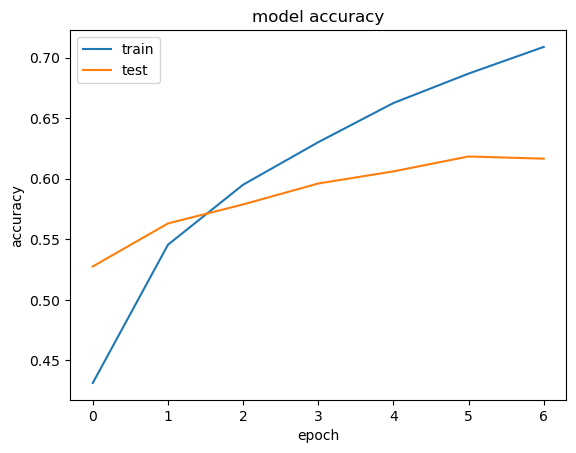

In [22]:
plothist(history_2)

## Учимся учить

А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от количества итераций.

Вам потребуется реализовать _экспериментальный стенд_ — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью `keras.callbacks` — `TensorBoard` или `History`.

Будьте морально готовы, что на обучение уйдёт _много времени_. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

**Задание 1.3 (опционально)** Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

Для удобства напишем класс Evaluator, который принимает в себя дикты виды {имя_оптимайзера: инстанс}, {имя модели: инстанс} и обучает всевозможные комбинации моделей с оптимайзерами при помощи метода fit (попутно записывая логи отдельно для каждой модели). Также пригодится метод evaluate для отображения итоговых скоров.

Пользоваться классом не обязательно. По умолчанию класс использует tensorboard. Если вы выше использовали wandb -- советуем дописать callback.

In [23]:
from tqdm.notebook import tqdm

In [24]:
class Evaluator(list):
    def __init__(self, models, optimizers='adam', loss=keras.losses.categorical_crossentropy,
                 metrics=[keras.metrics.categorical_accuracy]):
        '''
            models: dict {name: model}
            optimizers: list of optimizers or just one optimizer
        '''
        if not isinstance(models, dict):
            models = {'single_model': models}
        if not isinstance(optimizers, dict):
            optimizers = {str(optimizers.__class__): optimizers}
        super().__init__([(model_name, keras.models.clone_model(model), optimizer_name, optimizer)
                          for model_name, model in models.items()
                          for optimizer_name, optimizer in optimizers.items()])
        for _, model, _, optimizer in self:
            model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def fit(self, X, y, validation_data=(), max_epochs=100, verbose=0, callbacks=[], batch_size=32):
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm(self):
            history = model.fit(X, y, validation_data=validation_data or None, epochs=max_epochs, verbose=verbose,
                                batch_size=batch_size,
                                callbacks=callbacks) # + [keras.callbacks.TensorBoard(
                       # log_dir = os.path.join('logs', '{}_{}'.format(model_name, optimizer_name)))])
                        # log_dir='logs\\{}_{}'.format(model_name, optimizer_name))])
            # plt.plot(history.history['loss'])
            # plt.plot(history.history['val_loss'])
            # plt.title('model loss')
            # plt.ylabel('loss')
            # plt.xlabel('epoch')
            # plt.legend(['train', 'val'], loc='upper left')
            # plt.show()   
            print(history.history.keys())

    def fit_generator(self, X, y, validation_data=(), max_epochs=100, verbose=1, callbacks=[], batch_size=32):
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True
        )
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm(self):
            history = model.fit_generator(datagen.flow(X, y, batch_size=batch_size), epochs=max_epochs,
                                          validation_data=validation_data or None, verbose=verbose,
                                          callbacks=callbacks) # + [keras.callbacks.TensorBoard(
                   # log_dir = os.path.join('logs', '{}_{}'.format(model_name, optimizer_name)))])
                    # log_dir='logs\\{}_{}'.format(model_name, optimizer_name))])
            # plt.plot(history.history['loss'])
            # plt.plot(history.history['val_loss'])
            # plt.title('model loss')
            # plt.ylabel('loss')
            # plt.xlabel('epoch')
            # plt.legend(['train', 'val'], loc='upper left')
            # plt.show()
            print(history.history.keys())

    def evaluate(self, X, y, metric):
        for model_name, model, optimizer_name, _ in self:
            print('Final score of {}_{} is {}'.format(model_name, optimizer_name,
                  metric(y_test, model.predict(X_test))))

In [25]:
# !rm -rf ./logs

In [26]:
# optimizers = {
#     # 'optimizer_name': optimizer
# }

from tensorflow.keras import optimizers
optimizers = { 'SGD': optimizers.SGD(),
               'Adam': optimizers.Adam()
              }

In [27]:

# model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [28]:
# evaluator = Evaluator(model, optimizers=optimizers)
# evaluator.fit(X_train, y_train, validation_data=(X_val, y_val))
# evaluator.evaluate(X_test, y_test, accuracy_score)

Прокомментируйте полученные результаты.

> Делал разные манипуляции, но так и не смог победить. Ошибка всегда выскакивает. Захайдил, так как выполенение evaluation занимает около часа <br>

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

**Задание 1.4 (опционально)** Добавьте нормализацию по батчу (`BatchNormalization`) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях.

Для удобства реализуем класс Models, который по сути будет являться списком моделей с двумя методами: add (добавить слой ко всем моделям) и add_create (создать новую модель на основе базовой с дополнительным слоем). Пользоваться им необязательно, но вдруг :)

In [29]:
from collections import OrderedDict

class Models(OrderedDict):
    def __init__(self, models):
        if not isinstance(models, dict):
            models = OrderedDict({'base_model': models})
        super().__init__(models)

    def add(self, layer):
        for name, model in self.items():
            model.add(layer)

    def add_create(self, name, layer):
        base_model = next(iter(self.items()))[1]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

    def add_update(self, name, layer):
        base_model = self[next(reversed(self))]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

# Example of usage
# models = Models(keras.Sequential())
# models.add(L.InputLayer(input_shape=(32, 32, 3)))
# models.add(L.Convolution2D(filters=10, kernel_size=(3, 3)))
# models.add(L.MaxPooling2D())
# models.add_create('conv_batchnorm', L.BatchNormalization())
# models.add(L.Activation('relu'))


In [30]:
model_1 = Sequential([
    L.Conv2D(filters = 15,
             kernel_size = (5, 5),
             padding = 'same',
             activation = 'relu',
             input_shape = (32, 32, 3)),
    L.BatchNormalization(),
    L.Conv2D(filters = 10,
             kernel_size = (3, 3),
             padding = 'same',
             activation = 'relu'),
    L.BatchNormalization(),  # добавил Batch Normalization
    L.MaxPooling2D(pool_size = (2, 2), padding = 'valid'),
    
    L.Flatten(),# (N,C,H,W) --> (N, C*H*W)
    L.Dense(100, activation = 'relu'),
    L.BatchNormalization(),
    L.Dense(10, activation = 'softmax')])

In [31]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 15)        1140      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 15)        60        
 Normalization)                                                  
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 10)        1360      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 10)        40        
 chNormalization)                                                
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 10)        0         
 g2D)                                                            
                                                      

In [32]:
model_1.compile(optimizer = 'adam',
                     loss = loss_fn,
                     metrics = ['accuracy'])

In [33]:
history_3 = model_1.fit(X_train,
                        y_train,
                        epochs = 10,
                        validation_data = (X_val, y_val),
                        callbacks = [tf.keras.callbacks.EarlyStopping(patience = 2)])

Epoch 1/10
1250/1250 [==============================] - 79s 62ms/step - loss: 1.4131 - accuracy: 0.4994 - val_loss: 1.3245 - val_accuracy: 0.5399
Epoch 2/10
1250/1250 [==============================] - 79s 63ms/step - loss: 1.0748 - accuracy: 0.6204 - val_loss: 1.2231 - val_accuracy: 0.5619
Epoch 3/10
1250/1250 [==============================] - 78s 63ms/step - loss: 0.9381 - accuracy: 0.6693 - val_loss: 1.1288 - val_accuracy: 0.6106
Epoch 4/10
1250/1250 [==============================] - 79s 63ms/step - loss: 0.8300 - accuracy: 0.7101 - val_loss: 1.2411 - val_accuracy: 0.5872
Epoch 5/10
1250/1250 [==============================] - 79s 63ms/step - loss: 0.7387 - accuracy: 0.7404 - val_loss: 1.0572 - val_accuracy: 0.6460
Epoch 6/10
1250/1250 [==============================] - 77s 61ms/step - loss: 0.6430 - accuracy: 0.7740 - val_loss: 1.0962 - val_accuracy: 0.6330
Epoch 7/10
1250/1250 [==============================] - 80s 64ms/step - loss: 0.5572 - accuracy: 0.8049 - val_loss: 1.1097 -

In [34]:
predict_x = model_1.predict(X_test)

classes_x = np.argmax(predict_x,axis = 1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)

313/313 [==============================] - 3s 11ms/step

 Test_acc = 0.639


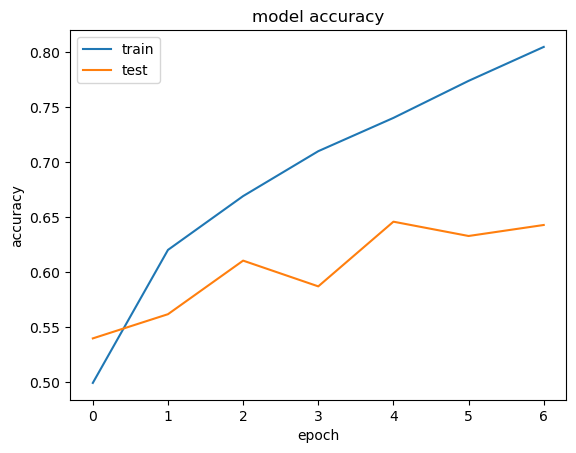

In [35]:
plothist(history_3)

Прокомментируйте полученные результаты.

In [36]:
# Нормализация по батчу не улучшила модель к сожалению.


**Задание 1.5 (опционально)** Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху).
Найдите такое значение, при котором модель быстрее достигает точности 55%. **Hint**: используйте early stopping callback.

In [37]:
model_2 = Sequential([
    L.Conv2D(filters = 15,
             kernel_size = (5, 5),
             padding = 'same',
             activation = 'relu',
             input_shape = (32, 32, 3)),
    L.BatchNormalization(),
    L.Conv2D(filters = 10,
             kernel_size = (3, 3),
             padding = 'same',
             activation = 'relu'),
    L.BatchNormalization(),  # добавил Batch Normalization
    L.MaxPooling2D(pool_size = (2, 2), padding = 'valid'),
    
    L.Flatten(),# (N,C,H,W) --> (N, C*H*W)
    L.Dense(100, activation = 'relu'),
    L.BatchNormalization(),
    L.Dense(10, activation = 'softmax')])

In [38]:
# Создание модели
model_2.compile(optimizer = 'adam',
                     loss = loss_fn,
                     metrics=['accuracy'])

In [39]:
history_4 = model_2.fit(X_train,
                        y_train,
                        epochs = 100,
                        batch_size = 32,
                        validation_data = (X_val, y_val),
                        callbacks = [tf.keras.callbacks.EarlyStopping(patience = 2)])

Epoch 1/100
1250/1250 [==============================] - 77s 60ms/step - loss: 1.3909 - accuracy: 0.5128 - val_loss: 1.2408 - val_accuracy: 0.5662
Epoch 2/100
1250/1250 [==============================] - 75s 60ms/step - loss: 1.0696 - accuracy: 0.6241 - val_loss: 1.1749 - val_accuracy: 0.5844
Epoch 3/100
1250/1250 [==============================] - 76s 61ms/step - loss: 0.9498 - accuracy: 0.6694 - val_loss: 1.1395 - val_accuracy: 0.6114
Epoch 4/100
1250/1250 [==============================] - 78s 62ms/step - loss: 0.8524 - accuracy: 0.7019 - val_loss: 1.0430 - val_accuracy: 0.6446
Epoch 5/100
1250/1250 [==============================] - 76s 60ms/step - loss: 0.7580 - accuracy: 0.7361 - val_loss: 1.0490 - val_accuracy: 0.6497
Epoch 6/100
1250/1250 [==============================] - 77s 61ms/step - loss: 0.6795 - accuracy: 0.7624 - val_loss: 1.0781 - val_accuracy: 0.6423


In [40]:
predict_x = model_1.predict(X_test)

classes_x = np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)

313/313 [==============================] - 3s 11ms/step

 Test_acc = 0.639


In [41]:
# 128
# 313/313 [==============================] - 2s 7ms/step
# Test_acc = 0.5955

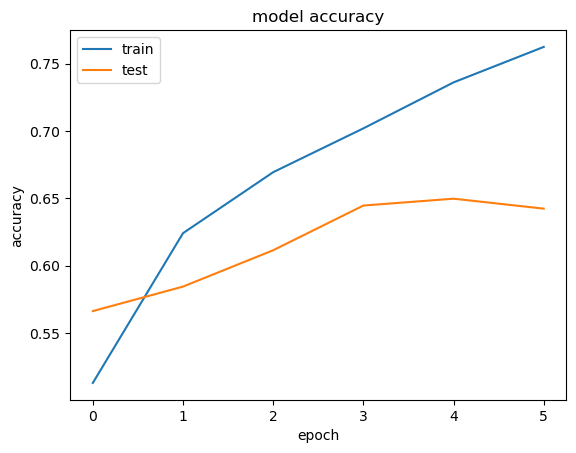

In [42]:
plothist(history_4)

**Задание 1.6 (опционально)** Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Поясните, что вы понимаете под "наилучшей" кривой обучения.

In [43]:
# Когда сеть обучается без существенных отклонений на тренеровочных и тестовых данных - не должно быть резких изменений на графике тестовых данных.

In [44]:
from keras.optimizers import Adam, RMSprop
from keras.callbacks import LearningRateScheduler

In [45]:

model_best = Sequential([
    L.Conv2D(filters = 15,
             kernel_size = (5, 5),
             padding = 'same',
             activation = 'relu',
             input_shape = (32, 32, 3)),
    
    L.BatchNormalization(),  

    L.Conv2D(filters = 10,
             kernel_size = (3, 3),
             padding = 'same',
             activation = 'relu'),
    
    L.BatchNormalization(),  

    L.MaxPool2D(pool_size = (2, 2), padding = 'valid'),

    L.Flatten(),# (N,C,H,W) --> (N, C*H*W)
    L.Dense(100, activation = 'relu'),
    L.BatchNormalization(),  
    L.Dense(10, activation = 'softmax')])


In [46]:
# Определение функции обучения
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.9

In [85]:

optimizer = Adam(learning_rate = 0.001)

In [48]:
# Определение callback
callbacks = [tf.keras.callbacks.EarlyStopping(patience = 5), LearningRateScheduler(scheduler)]
# callbacks = [tf.keras.callbacks.EarlyStopping, LearningRateScheduler(scheduler)]

In [49]:
# Компиляция модели
model_best.compile(optimizer = optimizer,
                   loss = loss_fn,
                   metrics = ['accuracy'])


In [50]:
# Обучение модели
history_5 = model_best.fit(X_train,
                           y_train,
                           epochs = 50,
                           # batch_size = 32,
                           validation_data = (X_val, y_val),
                           callbacks = callbacks)


Epoch 1/50
1250/1250 [==============================] - 78s 60ms/step - loss: 1.4076 - accuracy: 0.4988 - val_loss: 1.2781 - val_accuracy: 0.5555 - lr: 0.0010
Epoch 2/50
1250/1250 [==============================] - 74s 60ms/step - loss: 1.0782 - accuracy: 0.6217 - val_loss: 1.1142 - val_accuracy: 0.6090 - lr: 0.0010
Epoch 3/50
1250/1250 [==============================] - 77s 62ms/step - loss: 0.9296 - accuracy: 0.6754 - val_loss: 1.1321 - val_accuracy: 0.6150 - lr: 0.0010
Epoch 4/50
1250/1250 [==============================] - 76s 61ms/step - loss: 0.8261 - accuracy: 0.7122 - val_loss: 1.0791 - val_accuracy: 0.6304 - lr: 0.0010
Epoch 5/50
1250/1250 [==============================] - 76s 61ms/step - loss: 0.7271 - accuracy: 0.7453 - val_loss: 1.1752 - val_accuracy: 0.6177 - lr: 0.0010
Epoch 6/50
1250/1250 [==============================] - 76s 61ms/step - loss: 0.6469 - accuracy: 0.7738 - val_loss: 1.1395 - val_accuracy: 0.6329 - lr: 0.0010
Epoch 7/50
1250/1250 [========================

In [51]:
predict_x = model_best.predict(X_test)

classes_x = np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)

313/313 [==============================] - 4s 11ms/step

 Test_acc = 0.639


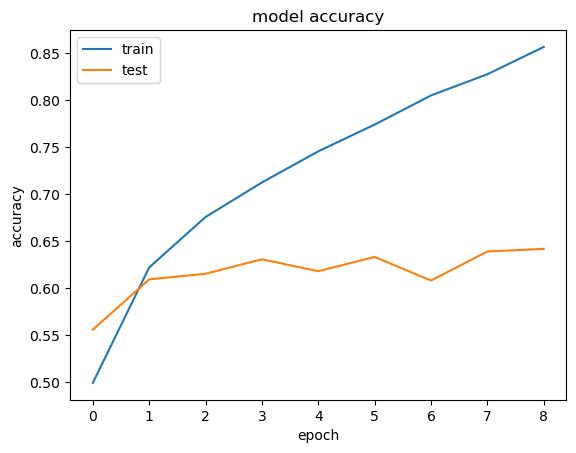

In [52]:
plothist(history_5)

## Свёрточная нейросеть здорового человека

**Задание 1.7 (обязательно попытаться)** Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке __accuracy больше 80%__. В этом задании вам потребуется провести эксперименты, сравнив их между собой в конце. Возможно, может быть несколько проще, если писать выводы во время или сразу после каждого эксперимента, после чего сделать общие выводы.

Рекомендуем начать с лучшей модели предыдущего задания и постепенно её улучшать. Вы можете использовать всё, что угодно: любые активации, сколь угодно большие свёрточные слои и глубокие сети. Единственное ограничение: __нельзя использовать предобученные сети и дополнительные данные__.

### Полезные советы
* Для начала, неплохо бы научить что-нибудь побольше, чем 10 фильтров 3x3.
* __Главное правило: одно изменение на эксперимент__. Если у вас есть 2 идеи по улучшению сети, сначала попробуйте их независимо. Может оказаться, что одно из них дало __+10%__ точности а другое __-7%__. А вы так и будете думать, что сделали 2 полезных изменения которые в сумме дают __+3%__. Если какая-то идея не работает — даже если она вам нравится - опишите ее и выкидывайте из дальнейших экспериментов.
* __Be careful or you will dropout__. Дропаут (`L.Dropout`) может позволить вам обучить в несколько раз бОльшую сеть без переобучения, выжав несколько процентов качества. Это круто, но не стоит сразу ставить dropout 50%. Во-первых, слишком сильный дропаут только ухудшит сеть (underfitting). Во-вторых, даже если дропаут улучшает качество, он замедляет обучение. Рекомендуем начинать с небольшого дропаута, быстро провести основные эксперименты, а потом жахнуть в 2 раза больше нейронов и дропаута ~~на ночь~~.
* __Аугментация данных__. Если котика слегка повернуть и подрезать (простите), он всё равно останется котиком. А в керасе есть [удобный класс](https://keras.io/preprocessing/image/), который поставит подрезание котиков на поток. Ещё можно сделать этот трюк в тесте: вертим картинку 10 раз, предсказываем вероятности и усредняем. Только один совет: прежде, чем учить, посмотрите глазами на аугментированные картинки. Если вы сами не можете их различить, то и сеть не сможет.
* __Don't just stack more layers__. Есть более эффективные способы организовать слои, чем простой Sequential. Вот пара идей: [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions](https://arxiv.org/abs/1608.06993). Только не копируйте архитектуру подчистую — вам скорее всего хватит меньшего размера.
* __Долго != плохо__. Более глубокие архитектуры обычно требуют бОльше эпох до сходимости. Это значит, что в первые несколько эпох они могут быть хуже менее глубоких аналогов. Дайте им время, запаситесь чаем и обмажьтесь batch-norm-ом.

In [86]:

model_best_2 = Sequential([
    L.Conv2D(filters = 64,
             kernel_size = (5, 5),
             padding = 'same',
             activation = 'relu',
             input_shape = (32, 32, 3)),
    
    L.BatchNormalization(),  

    L.Conv2D(filters = 32,
             kernel_size = (3, 3),
             padding = 'same',
             activation = 'relu'),
    
    L.BatchNormalization(),  
    
    L.Conv2D(filters = 10,
             kernel_size = (3, 3),
             padding = 'same',
             activation = 'relu'),
    
    L.BatchNormalization(), 

    L.MaxPool2D(pool_size = (2, 2), padding = 'valid'),
    L.Dropout(0.5),
    L.Flatten(),# (N,C,H,W) --> (N, C*H*W)
    L.Dense(100, activation = 'relu'),
    L.BatchNormalization(),  
    L.Dense(10, activation = 'softmax')])

In [87]:
model_best_2.compile(optimizer = optimizer,
                   loss = loss_fn,
                   metrics = ['accuracy'])

In [88]:
history_6 = model_best_2.fit(X_train,
                           y_train,
                           epochs = 50,
                           batch_size = 32,
                           validation_data = (X_val, y_val),
                           callbacks = [tf.keras.callbacks.EarlyStopping(patience = 5)])


Epoch 1/50
1250/1250 [==============================] - 261s 208ms/step - loss: 1.5249 - accuracy: 0.4588 - val_loss: 1.2944 - val_accuracy: 0.5436
Epoch 2/50
1250/1250 [==============================] - 256s 204ms/step - loss: 1.1956 - accuracy: 0.5765 - val_loss: 1.1134 - val_accuracy: 0.5980
Epoch 3/50
1250/1250 [==============================] - 257s 206ms/step - loss: 1.0625 - accuracy: 0.6219 - val_loss: 0.9861 - val_accuracy: 0.6429
Epoch 4/50
1250/1250 [==============================] - 267s 214ms/step - loss: 0.9795 - accuracy: 0.6544 - val_loss: 0.9909 - val_accuracy: 0.6437
Epoch 5/50
1250/1250 [==============================] - 263s 211ms/step - loss: 0.9127 - accuracy: 0.6763 - val_loss: 1.2197 - val_accuracy: 0.5671
Epoch 6/50
1250/1250 [==============================] - 270s 216ms/step - loss: 0.8575 - accuracy: 0.6973 - val_loss: 0.9305 - val_accuracy: 0.6730
Epoch 7/50
1250/1250 [==============================] - 266s 213ms/step - loss: 0.8165 - accuracy: 0.7090 - val_

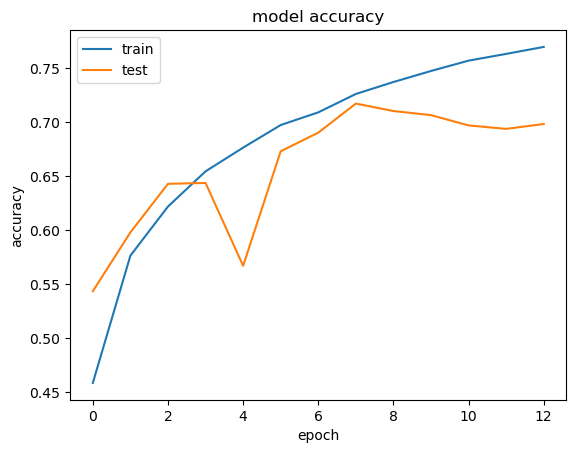

In [89]:
plothist(history_6)

Момент истины: проверьте, какого качества достигла ваша сеть.

In [90]:
from sklearn.metrics import accuracy_score

predict_x=model_best_2.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

313/313 [==============================] - 10s 30ms/step

 Test_acc = 0.7004


А теперь, опишите свои <s>ощущения</s> результаты от проведенных экспериментов.

К сожалению не хватает вычисилительных мощностей, каждая модель работает по 10 - 15 минут,<br>
evaluation работала больше часа, и не смотря на то, что я применял разные методики у меня так <br>
и не получилось справится с ошибкой, которую я отправлял Ивану. (тензербоурд вообще отказался запускаться <br>
даже при всех установок и ноутбук Ивана с лекции так же не сработал, к сожалению. Возможно это проблема корпоративного ноута. <p>

Интересно наблюдать за графиками, которые показывают как модель отрабатывает. Пока решал задачи, <br>
нагуглил много новой интересной информации и методов, который постарался тут реализовать.

В целом интересная задача и если бы мой ноутбук не зависал на каждой задаче, то просцесс был бы проще и успешней.<br>
хочу в будущем попробовать использовать стационарный компьютер, но надо купить видеокарты для более быстрой обработки